# Pricing Houses

In [2]:
%matplotlib inline

import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, Math

from featureNormalize import featureNormalize
from linearRegCostFunction import linearRegCostFunction
from trainLinearReg import trainLinearReg
from plot2DFit import plot2DFit
from MyPlotterClass import MyPlotterClass
from LearningCurveClass import LearningCurveClass
import dataFuncs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

pos = [1920, 28, 1920, 1052]

myplots = MyPlotterClass(pos)
plt.style.use('yb_pres')

myCurves = LearningCurveClass()

%load_ext autoreload
%autoreload 2

# Data Cleaning and Selection

Missing data equals nan (or -1 for converted numerical labels)

In [5]:
df_num = dataFuncs.loadAndPrepNumData('train.csv')

#compute mu and std of features (except Sales Price and Id)
df_dum = df_num.drop(columns=['SalePrice','Id'],errors='ignore')
(df_dum,mu,std) = featureNormalize(df_dum)


### High Leverage Points
#ind = dataFuncs.identifyHighLeverage(df_dum)
#df_num[ind]

Remaining missing data from train set:
Series([], dtype: int64)


## Correlations Between Features

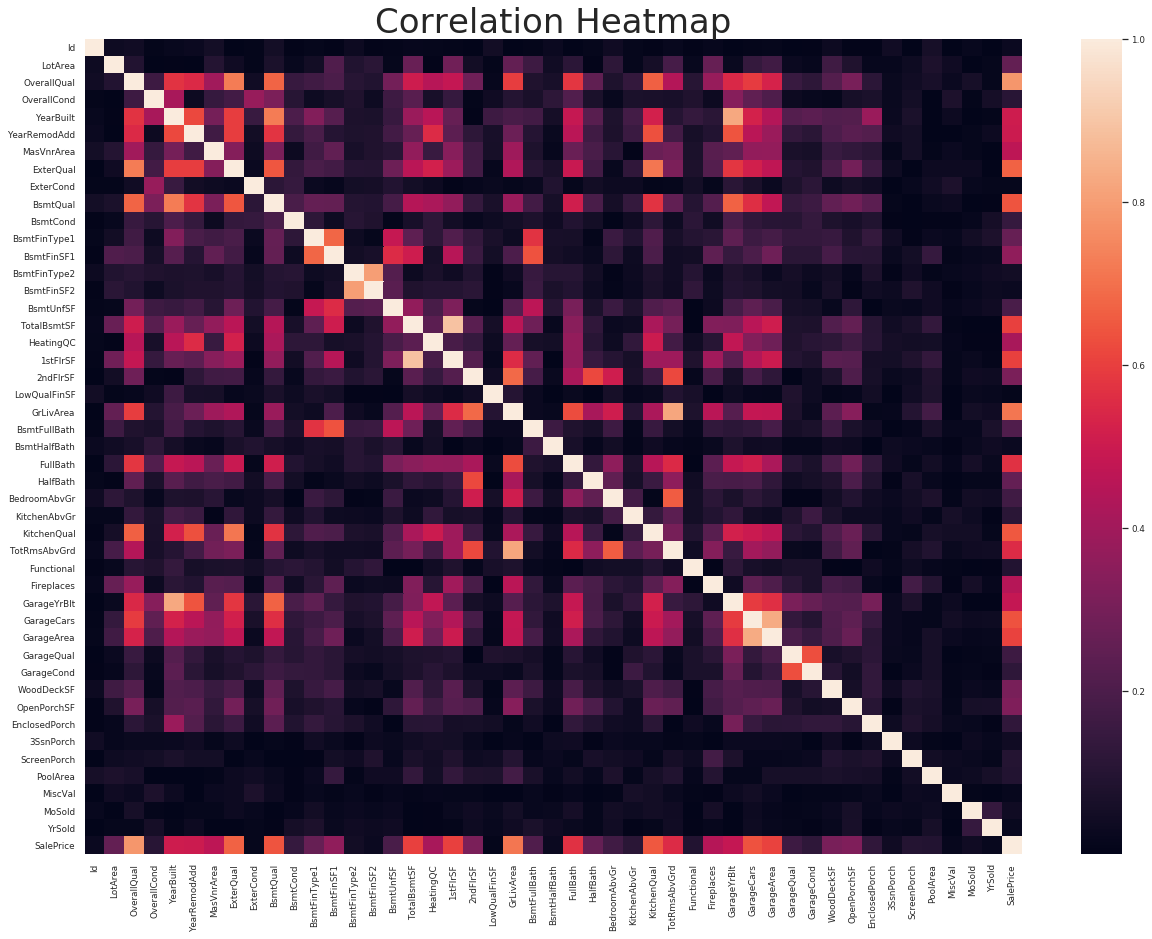

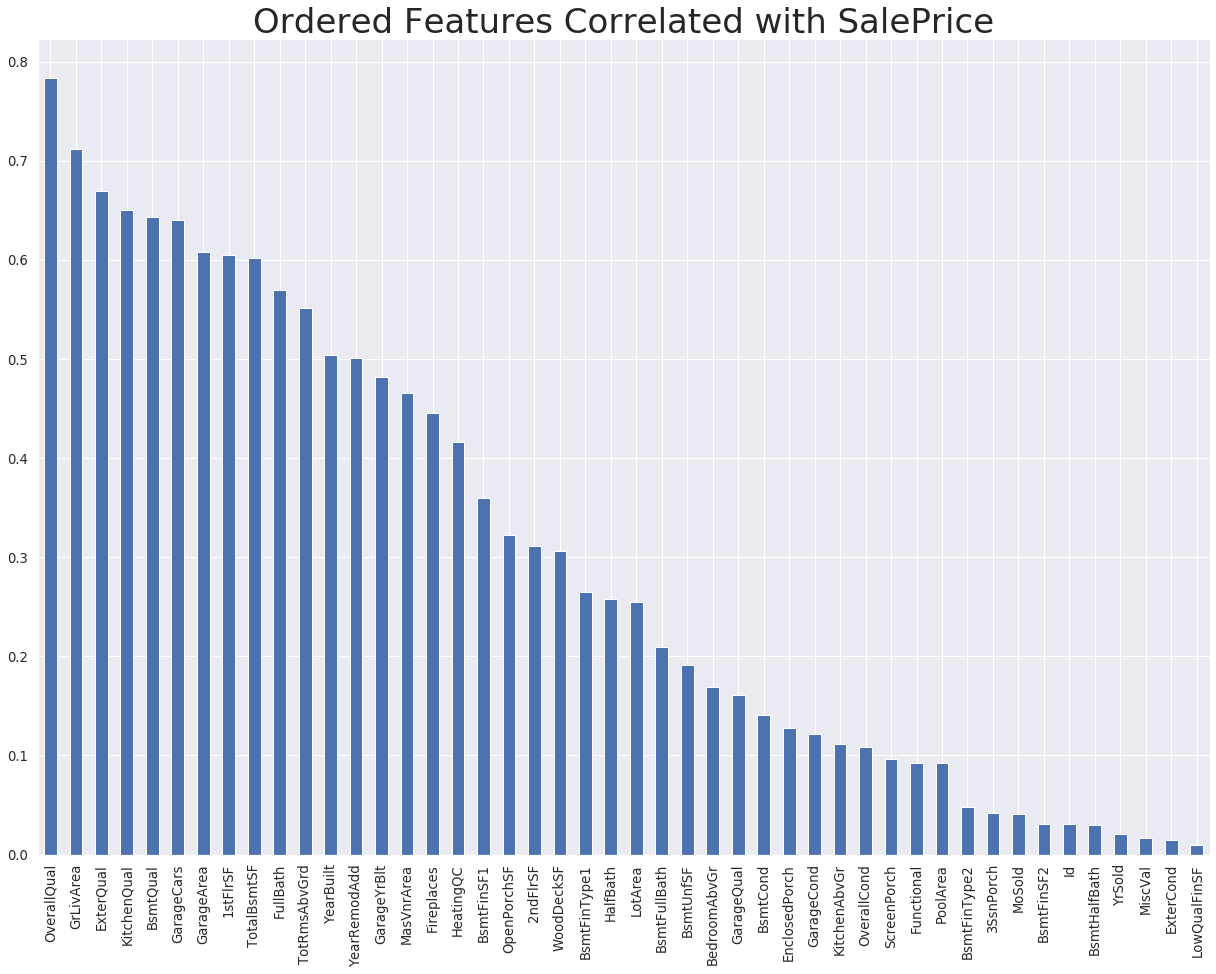

In [79]:
#%matplotlib qt
#import matplotlib.pyplot as plt
myplots.plotCorrleations(df_num)

# Choice Method: Regularized Regression on Numerical Data

### Cost function
The **validation** cost fuction as outlined in the evaluation critera is as follows:
$$MSE = \frac{1}{m} \sum_i (\log{\hat{y_i}}-\log{y_i})^2$$
where $\log{\hat{y_i}}=x_i\cdot\theta$ and $\hat{y_i}$ and $y_i$ are the predicted and actual sales price for each example $i$. 

### Link to average percent error in price to get benchmark/target MSE...
A cost function goal can be defined as a relative error in price $\epsilon_r = \frac{y_i - \hat{y_i}}{y_i}$. 
The equivalent value of the cost function for a given $\epsilon_r$ can be worked out to be:

$$MSE = [\log(1-\epsilon_r)]^2$$

## Why linear regression?
* simple
* easy to interpret
* familiar and well-understood
* can be quickly build up from scratch
* good model to start with before moving on to more sophisticated methods

## Choice of method for high dimensions: Regulariziation
To preserve the original features while isolating essential features, use L1 or L2 regularization for the **training**:
$$L2: MSE = \frac{1}{m} \sum_{i=0}^{m} (x_i\cdot\theta-\log{y_i})^2 + \frac{\lambda}{2m} \sum_{j=1}^n (\theta^{(j)})^2 $$

$$L1: MSE = \frac{1}{m} \sum_{i=0}^{m} (x_i\cdot\theta-\log{y_i})^2 + \frac{\lambda}{2m} \sum_{j=1}^n |\theta^{(j)}| $$

# Preliminary Fits and Outliers

Optimization terminated successfully.
         Current function value: 0.009589
         Iterations: 48
         Function evaluations: 82
         Gradient evaluations: 82
Train MSE:	 0.0096
Validation MSE:	 0.0098
10.0% Goal:	 0.0111
5.0% Goal:	 0.0026


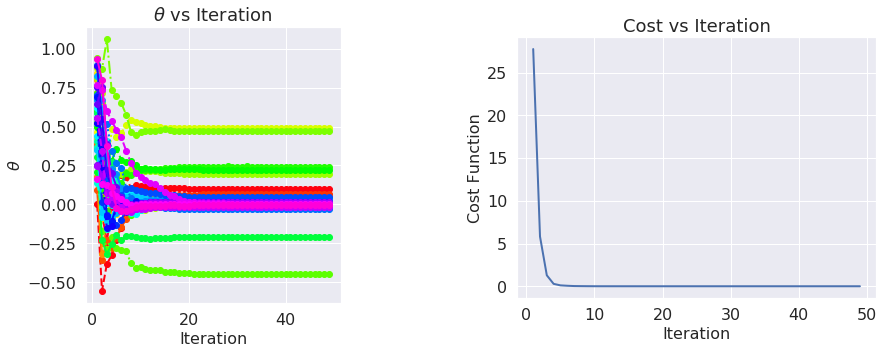

In [80]:
##get test/train split
X,y,Xval,yval,Id,Id_val,labels = dataFuncs.get_test_train_sets(df_num,mu,std,cv_frac=0.3)#includes bias

#train a single model
myCurves.set_reg('L1')
Lambda = 0
results, error_train, error_val = myCurves.singleFit(X,y,Xval,yval,Lambda,labels)
theta = results.x



### Residual Analysis

When plotting the residual distributions, a few outliers are present. Outliers on their own can overestimate the MSE. We can choose to exclude them from the MSE calculation by cutting on points more than 5 $\sigma$ away. 

Outliers that are both high leverage points may compromise the fit parameters. To check this I can identify whether the two high residual points have extreme feature values. I can also check whether removing the points from the data affects the MSE when excluding them from the MSE calculation either way.

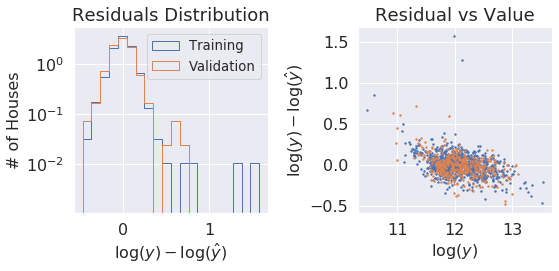

In [81]:
myplots.plotResiduals(X,y,Xval,yval,theta);

In [82]:
#Identify outliers as having residuals more than 6 sigma away from the mean
outlier_Ids=dataFuncs.identifyOutliers(X,y,Id, Xval,yval,Id_val, theta,sig_cut=6)
df_outlier = df_num.loc[outlier_Ids.index,:]
df_outlier
df_num_sans_outliers = df_num.drop(index=outlier_Ids.index)

In [ ]:
## look at oultiers in the context of distributions of features in the data

# plotcol = ['GarageArea','Fireplaces','TotRmsAbvGrd','GrLivArea','1stFlrSF','BsmtFinSF1']
# print(df_outlier[['Id']+ plotcol])

# myplots.plotDists(df_num,plotcol[0:4],ilog=True)
# fig=plt.gcf();
# ax = fig.axes; 
# [ax[i].vlines(df_outlier[plotcol[i]],0,100) for i in range(4)];

# myplots.plotDists(df_num,plotcol[4:7],ilog=True)
# fig=plt.gcf();
# ax = fig.axes;
# [ax[i].vlines(df_outlier[plotcol[i+4]],0,100) for i in range(2)];



### MSE estimation with resampling

Perform shuffle split 200 times to estimate MSE (bootstrapping without replacement).

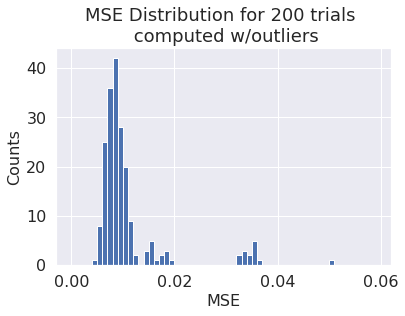

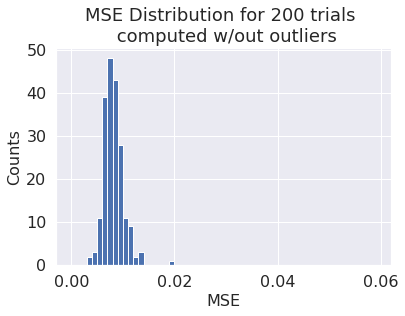

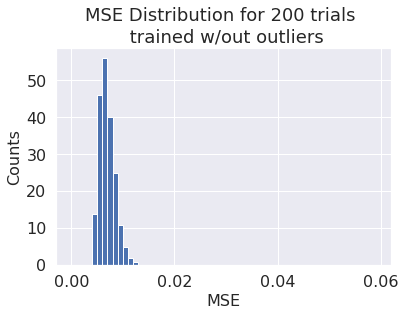

In [83]:
n_trials = 200

#keep outliers within fit and MSE calculation
myCurves.exclude_outs_from_MSE = False
_,_,MSE_val_1,MSE_val_SE_1 = myCurves.resampleFit(n_trials,df_num,mu,std,icv_frac=0.3,Lambda=0,plotDists=False)
plt.title('MSE Distribution for ' + str(n_trials) + ' trials \n computed w/outliers');

#exclude outliers from MSE calculation but keep in fit
myCurves.set_MSE_exclude_Id(outlier_Ids)
_,_,MSE_val_2,MSE_val_SE_2 = myCurves.resampleFit(n_trials,df_num,mu,std,icv_frac=0.3,Lambda=0,plotDists=False)
plt.title('MSE Distribution for ' + str(n_trials) + ' trials \n computed w/out outliers');

#exclude outliers from both fits and MSE calculation
_,_,MSE_val_3,MSE_val_SE_3 = myCurves.resampleFit(n_trials,df_num_sans_outliers,mu,std,icv_frac=0.3,Lambda=0,plotDists=False)
plt.title('MSE Distribution for ' + str(n_trials) + ' trials \n trained w/out outliers');

In [84]:
delMSE = MSE_val_2-MSE_val_3
errdelMSE = np.sqrt(MSE_val_SE_3**2/n_trials + MSE_val_SE_2**2/n_trials)
display(Math(r"\Delta MSE = {0:.4f}\pm{1:.4f}".format(delMSE,errdelMSE)))

<IPython.core.display.Math object>

### Conclusions on outliers
* Outliers significantly affect the MSE computation and the fit itself. 
* May correspond to legitimate data: extreme valued features that do not fit with the linear model.
* OR anomolous data points that are not part of the general population.
* Choose to remove from fit.


In [85]:
df_num = df_num_sans_outliers
df_dum = df_num.drop(columns=['SalePrice','Id'])
(df_dum,mu,std) = featureNormalize(df_dum)

# Model Tuning
### Tune regularization parameter $\lambda$

In [ ]:
# Lambda_array = np.logspace(-2,1,10, endpoint=False)
Lambda_array = np.linspace(0,10,10)
##get test/train split
X,y,Xval,yval,Id,Id_val,labels = dataFuncs.get_test_train_sets(df_num,mu,std,cv_frac=0.3)#includes bias

error_train, error_val, Lambda_array = myCurves.validationCurve(X, y, Xval, yval, Lambda_array)
myCurves.plotErrorCurve(Lambda_array,error_train,error_val)
plt.xlabel('$\lambda$');

### Validation Curve for L1 Regularization

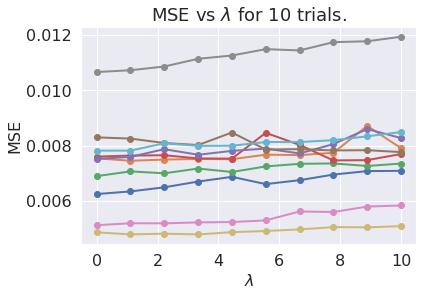

In [86]:
#Lambda_array = np.logspace(-2,1,10, endpoint=False)
Lambda_array = np.linspace(0,10,10)
n_trials = 10
myCurves.set_reg('L1')
myCurves.computeValidationCurveWithResampling(n_trials,Lambda_array,df_num,mu,std)

### Validation Curve for L2 Regularization

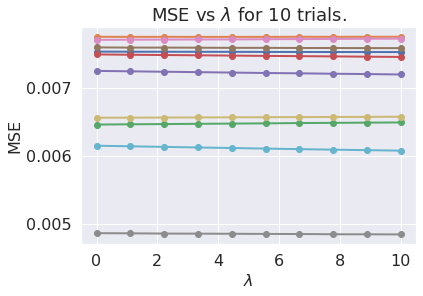

In [87]:
Lambda_array = np.linspace(0,10,10)
n_trials = 10
myCurves.set_reg('L2')
myCurves.computeValidationCurveWithResampling(n_trials,Lambda_array,df_num,mu,std)

### L1 vs L2 Regularization for given $\lambda$

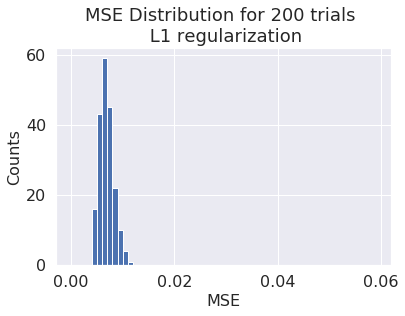

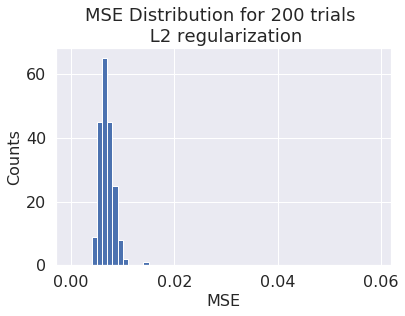

In [89]:
n_trials = 200
Lambda=1

myCurves.set_reg('L1')
_,_,MSE_L1,MSE_SE_L1 = myCurves.resampleFit(n_trials,df_num,mu,std,icv_frac=0.1,Lambda=Lambda,plotDists=False)
plt.title('MSE Distribution for ' + str(n_trials) + ' trials \n L1 regularization');

myCurves.set_reg('L2')
_,_,MSE_L2,MSE_SE_L2 = myCurves.resampleFit(n_trials,df_num,mu,std,icv_frac=0.1,Lambda=Lambda,plotDists=False)
plt.title('MSE Distribution for ' + str(n_trials) + ' trials \n L2 regularization');

In [90]:
delMSE = MSE_L1-MSE_L2
errdelMSE = np.sqrt(MSE_SE_L1**2/n_trials + MSE_SE_L2**2/n_trials)
display(Math(r"\Delta MSE = {0:.4f}\pm{1:.4f}".format(delMSE,errdelMSE)))

<IPython.core.display.Math object>

### Conclusions
Regularizing the parameters does not imporove the MSE. This could be a sign of high bias in the model or nonlinearity. 

Next steps:
* Check the linear model against off the shelf model for consistency.
* Try adding categorical data as dummy variables to see if MSE is improved.
* Try adding interaction terms. 
* Try a non-linear model such as random forests.

### Link to average percent error in price to get benchmark/target MSE...
A cost function goal can be defined as a relative error in price $\epsilon_r = \frac{y_i - \hat{y_i}}{y_i}$. 
The equivalent value of the cost function for a given $\epsilon_r$ can be worked out to be:

$$MSE = [\log(1-\epsilon_r)]^2$$

Below we compute the learning curve (cost vs # of training examples used) for training and validation set and compare it to the 10%,5%, and 1% cost goals. 

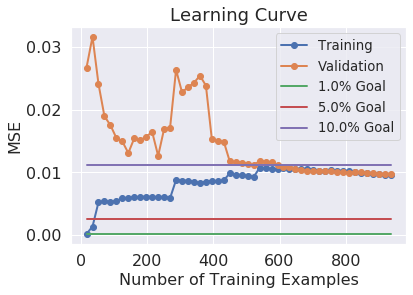

In [91]:
Lambda =1
error_train, error_val, n_ex = myCurves.learningCurve(X, y, Xval, yval, Lambda)
myCurves.plotErrorCurve(n_ex, error_train, error_val,plotGoals = True)
plt.xlabel('Number of Training Examples');
plt.title('Learning Curve');

### Parameter Error Estimates

In [ ]:
n_trials = 100
%matplotlib qt
theta,SE,MSE_val,MSE_val_SE = myCurves.resampleFit(n_trials,df_num,mu,std,icv_frac=0.1,Lambda=0)


In [62]:
# p_labels = ['Bias'] + list(df_num.columns)
# print("Parameter \t Value \t SE")
# #[print("%s \t %.2e \t %.2e" % (print_labels[i],theta[i],SE[i])) for i in range(theta.shape[0])]
# import statsmodels.api as sm
# model = sm.OLS(y,X).fit()
# [print("%s\t%.3f\t%.3f\t%.3f\t%.3f" % (p_labels[i],theta[i],model.params[i],SE[i],model.bse[i])) for i in range(theta.shape[0])];

In [ ]:
%matplotlib qt
import matplotlib as plt
myplots.plotErrorVsParams(X,y,Xval,yval,theta,labels);

Optimization terminated successfully.
         Current function value: 0.006413
         Iterations: 375
         Function evaluations: 602
         Gradient evaluations: 602
Train MSE:	 0.0064
Validation MSE:	 0.0063
10.0% Goal:	 0.0111
5.0% Goal:	 0.0026


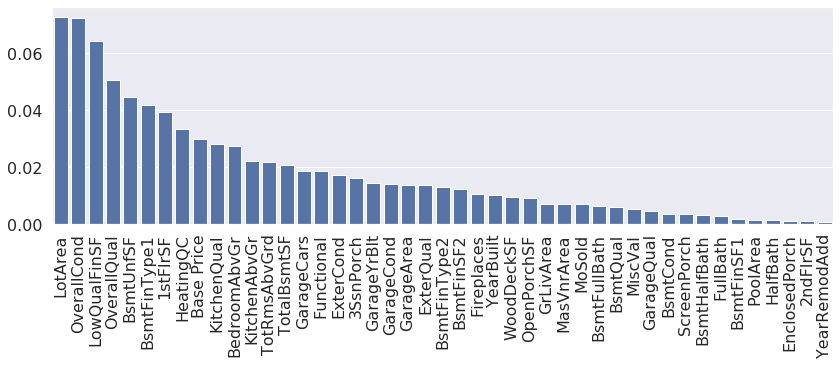

In [92]:
##get test/train split
X,y,Xval,yval,Id,Id_val,labels = dataFuncs.get_test_train_sets(df_num,mu,std,cv_frac=0.3)#includes bias

#train a single model
Lambda = 1
results, error_train, error_val = myCurves.singleFit(X,y,Xval,yval,Lambda,labels)
theta = results.x

%matplotlib inline
import seaborn as sns
fig = plt.figure(figsize=(14,4))
ind = np.argsort(abs(theta[1:]))
ind = ind[::-1]
ax = sns.barplot(np.array(labels)[ind],abs(theta[1:][ind]),color='b',saturation=.8)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90); 


In [ ]:
df_cat = df.select_dtypes('category')
[df_cat[el].dtypes for el in df_cat.columns]

df_cat_dummies = pd.get_dummies(df_cat)
print(df_cat.shape)
print(df_cat_dummies.shape)

df_num.shape

In [ ]:
df_dummies = pd.get_dummies(df)
print(df.shape)
df_dummies.shape